In [1]:
import numpy as np
from mha021 import *

In [2]:
# Problem 1

print('d)')

E = 200e9
A = 2e-4
P = 1e3
L = 1
b0 = - 2 * P / L

Le = L / 2

R = - 2 * P / L

# Assume constant load b(x) = b0

K = E * A / Le * np.array([[1, -1, 0],
                           [-1, 2, -1],
                           [0, -1 , 1]])

f = b0 * Le / 2 * np.array([[1],
                            [2],
                            [1]])

f[1 - 1] += P

bc_dofs = [2]
bc_vals = [0]

a, r = solve_eq(K, f, bc_dofs, bc_vals)

print(a[1-1])

d)
6.25e-06


Could not import Matplotlib backends. Probarbly due to missing Qt.


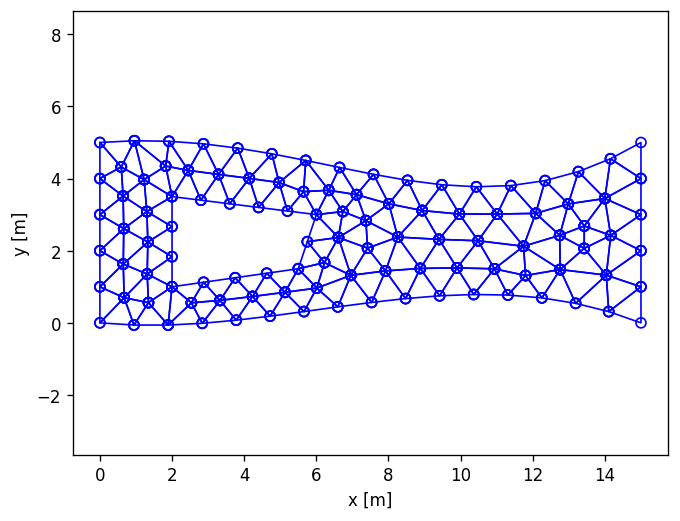

In [3]:
# Problem 2

# General packages
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# CALFEM packages
import calfem.core as cfc
import calfem.vis_mpl as cfv

# Load mesh data
mesh = scipy.io.loadmat('mesh_task2.mat') 

Coord = mesh['Coord']                         # [x, y] coords for each node
Dofs = mesh['Dofs']                           
Edof = mesh['Edof']                           # [element number, dof1, dof2, dof3]
Ex = mesh['Ex']                                
Ey = mesh['Ey']                               
right_dofs = mesh['right_dofs']                                                   
left_dofs = mesh['left_dofs']                          

# Plot the mesh
plotpar = np.array([1, 1, 2]) # parameters for line style, color, marker 
# cfv.eldraw2(Ex, Ey, plotpar)
cfv.eldraw2(Ex, Ey)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()

In [4]:
print('a)')

h = 0.5
k = 1
T1 = 20
T2 = 0
t = 0.01

D = k * np.eye(2)

num_el = Edof.shape[0]
num_dofs = np.max(Edof[:, 1:])

K = np.zeros((num_dofs, num_dofs))
f = np.zeros((num_dofs))

# Assemble stiffness matrix and load vector
for el in range(num_el):
    el_nodes = np.vstack([Ex[el, :], Ey[el, :]])
    el_nodes = el_nodes.T
    Ke, fe = flow2t_Ke_fe(el_nodes, t, D, h)
    
    dofs = Edof[el, 1:]
    assem(K, Ke, dofs)
    assem(f, fe, dofs)
    
"""
Not necessary this time
def fe_edge(nodes, qn, t):
    x1, y1 = nodes[0]
    x2, y2 = nodes[1]
    L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    fe_ed = qn * L * np.array([[1], [1]])
    return fe_ed

# Assemble load vector from edge contributions
# let's say right edge as example
num_edges = ...
for edge in range(num_edges):
    edge_nodes = 
    nodes = 
    fe = fe_edge(nodes, qn, t)
    dofs = edge_nodes + 1
    assem(f, fe, dofs)
"""

# Boundary conditions
bc_dofs_left = left_dofs.flatten()
bc_vals_left= np.ones_like(bc_dofs_left) * T1

bc_dofs_right = right_dofs.flatten()
bc_vals_right = np.ones_like(bc_dofs_right) * T2

# Combine boundary conditions
bc_dofs = np.hstack([bc_dofs_left, bc_dofs_right])
bc_vals = np.hstack([bc_vals_left, bc_vals_right])

#  Solve system
a, r = solve_eq(K, f, bc_dofs, bc_vals)

Ed = extract_dofs(a, Edof[:, 1:])
elements = Edof[:, :]
nodes = np.vstack([Ex[:, :], Ey[:, :]])
nodes = nodes.T

# Plot results
fig = plot_scalar_field(nodes, elements, Ed)
fig.show()

a)


ValueError: Ed must have shape (M, 4) corresponding to the elements.

In [5]:
# Problem 3

print('a)')

x1 = 0.014
x2 = 0.021
x3 = 0.018
x4 = 0.012

y1 = 0.010
y2 = 0.009
y3 = 0.018
y4 = 0.016

xi, eta = sp.symbols('xi, eta')

N1 = 1 / 4 * (1 - xi) * (1 - eta)
N2 = 1 / 4 * (1 + xi) * (1 - eta)
N3 = 1 / 4 * (1 + xi) * (1 + eta)
N4 = 1 / 4 * (1 - xi) * (1 + eta)

N_bar = sp.Matrix([[N1, N2, N3, N4]])

N_bar_func = sp.lambdify((xi, eta), N_bar, 'numpy')

N_bar_eval = N_bar_func(0.25, 0.15)

x_e = np.array([[x1],
                [x2],
                [x3],
                [x4]])
 
y_e = np.array([[y1],
                [y2],
                [y3],
                [y4]])

x_A = N_bar_eval @ x_e
y_A = N_bar_eval @ y_e 

print(f'x: {x_A}')
print(f'y: {y_A}')

a)
x: [[0.01686562]]
y: [[0.01390313]]


In [6]:
print('b)')

scale = 1e-5

u1x = 4.1 * scale
u2x = 3.5 * scale
u3x = 3.8 * scale
u4x = 3.7 * scale
u1y = 1.0 * scale
u2y = 1.6 * scale
u3y = 1.7 * scale
u4y = 1.5 * scale

a = np.array([[u1x],
              [u1y],
              [u2x],
              [u2y],
              [u3x],
              [u3y],
              [u4x],
              [u4y]])

N = sp.Matrix([[N1, 0, N2, 0, N3, 0, N4, 0],
              [0, N1, 0, N2, 0, N3, 0, N4]])

N_func = sp.lambdify((xi, eta), N, 'numpy')

u_A = N_func(0.25, 0.15) @ a

print(u_A)

b)
[[3.7465625e-05]
 [1.5187500e-05]]


In [7]:
print('c)')

def compute_Be_detJ(nodes, xi_val, eta_val):
    
    x_e = nodes[:, 0]
    y_e = nodes[:, 1]
    
    xi, eta = sp.symbols('xi, eta')

    N1 = 1 / 4 * (1 - xi) * (1 - eta)
    N2 = 1 / 4 * (1 + xi) * (1 - eta)
    N3 = 1 / 4 * (1 + xi) * (1 + eta)
    N4 = 1 / 4 * (1 - xi) * (1 + eta)

    Nbar = sp.Matrix([[N1, N2, N3, N4]])
    
    x = Nbar @ x_e
    y = Nbar @ y_e

    global_variables = sp.Matrix([x, y])
    local_variables = sp.Matrix([xi, eta])
        
    J = global_variables.jacobian(local_variables)
    
    dNbar_dxi = Nbar.diff(xi)
    dNbar_deta = Nbar.diff(eta)
    
    dNbar_dxi_func = sp.lambdify((xi, eta), dNbar_dxi, 'numpy')
    dNbar_deta_func = sp.lambdify((xi, eta), dNbar_deta, 'numpy')
    J_func = sp.lambdify((xi, eta), J, 'numpy')
    
    J_val = J_func(xi_val, eta_val)
    detJ = np.linalg.det(J_val)
    
    dNbar_dxi_val = dNbar_dxi_func(xi_val, eta_val)
    dNbar_deta_val = dNbar_deta_func(xi_val, eta_val)
    
    dNbar_dxieta = np.vstack((dNbar_dxi_val, dNbar_deta_val))
    
    dNbar_dxy = np.linalg.inv(J_val.T) @ dNbar_dxieta
    
    Be = np.zeros((3, 8))
    for i in range(4):
        i_dx = 2 * i 
        i_dy = 2 * i + 1
        
        Be[0, i_dx] = dNbar_dxy[0, i]
        Be[1, i_dy] = dNbar_dxy[1, i]
        Be[2, i_dy] = dNbar_dxy[0, i]
        Be[2, i_dx] = dNbar_dxy[1, i]
        
    return Be, detJ
    
nodes = np.array([[x1, y1],
                  [x2, y2],
                  [x3, y3],
                  [x4, y4]])

Be, detJ = compute_Be_detJ(nodes, 0, 0)

t = 0.025
E = 210e9
nu = 0.3
D = hooke_2d_plane_stress(E, nu)
Ke = t * Be.T @ D @ Be * detJ * 4

displayvar('Ke', Ke/1e9)

c)


<IPython.core.display.Math object>